# 1.准备工作

In [1]:
#解决pickle  mac上bug，使用dump_pickle和dump_load进行存取
class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size

def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)

def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

# 2.数据预处理及显示

In [2]:
#读取检查图像数据
#os.walk--os.listdir
import os
import numpy as np
import cv2

#train data
path='/imagedata/train'
class_list=[]
img_list=[]
current_path=os.getcwd()
abosult_path=current_path+path
for image_name in os.listdir(abosult_path):    
    class_list.append(image_name[0:3])
    img =cv2.imread(abosult_path+'/'+image_name,1)
    img_resize=cv2.resize(img,(256,200))
    img_list.append(img_resize)

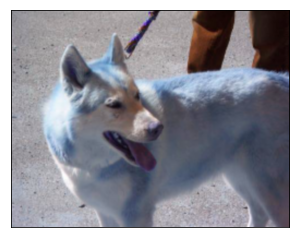

(200, 256, 3)
[[[129 129 135]
  [142 142 148]
  [143 143 149]
  ..., 
  [ 29  14  11]
  [ 34  14   9]
  [ 32  12   7]]

 [[137 137 143]
  [146 146 152]
  [141 141 147]
  ..., 
  [ 26  11   9]
  [ 34  15  10]
  [ 32  13   8]]

 [[139 139 145]
  [145 145 151]
  [138 138 144]
  ..., 
  [ 26  11   9]
  [ 28  10   5]
  [ 27   8   3]]

 ..., 
 [[165 172 188]
  [163 167 183]
  [165 171 185]
  ..., 
  [ 89  70  82]
  [ 90  71  80]
  [ 90  71  80]]

 [[159 166 181]
  [153 158 174]
  [152 157 172]
  ..., 
  [ 89  70  82]
  [ 89  70  79]
  [ 89  70  79]]

 [[165 172 187]
  [156 162 177]
  [142 147 162]
  ..., 
  [ 88  69  81]
  [ 87  68  77]
  [ 87  68  77]]]
dog


In [3]:
#显示图像及参数
from matplotlib import pyplot as plt

img_id=9

plt.imshow(img_list[img_id],cmap='gray',interpolation = 'bicubic')
plt.xticks([]),plt.yticks([])
plt.show()

print(img_list[img_id].shape)
print(img_list[img_id])
print(class_list[img_id])

In [4]:
#归一化
def normalize(x):
    return (x-x.min())/(x.max()-x.min())
            

In [5]:
#格式转换
class_list=np.array(class_list)
img_list=np.array(img_list)

In [6]:
#one-hot编码
from sklearn import preprocessing
def one_hot(x):
    lb = preprocessing.LabelBinarizer()
    
    return lb.fit_transform(x)

In [7]:
#save data
def save_data(features,labels,data_name):
    features=normalize(features)
    labels=one_hot(labels)
    pickle_dump((features,labels),'%s'%data_name)

In [8]:
#保存图像
import pickle

#分离测试集并保存
test_count=int(len(img_list)*0.1)
test_features = img_list[-test_count:]
test_labels = class_list[-test_count:]



save_data(test_features,test_labels,'test_data')


#剩余数据
train_img=img_list[:-test_count]
train_class=class_list[:-test_count]


#验证集保存
validation_count=int(len(train_img)*0.1)
valid_features = train_img[-validation_count:]
valid_labels = train_class[-validation_count:]

save_data(valid_features,valid_labels,'valid_data')


#数据分批次保存
n_batches = 5
    
#训练集    
m=int(len(train_img[:-validation_count])/n_batches)
n=0
for i in range (1,1+n_batches):
    if i ==1+n_batches:
        save_data(train_img[n:-validation_count],train_class[n:-validation_count],'train_data_batch%s'%str(i))
    else:
        save_data(train_img[n:n+m],train_class[n:n+m],'train_data_batch%s'%str(i))
    n=n+m
        

(2500,)
(2500, 200, 256, 3)
writing total_bytes=3072020250...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 2147483648)... done.
writing bytes [2147483648, 3072020250)... done.
writing total_bytes=2764818250...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 2147483648)... done.
writing bytes [2147483648, 2764818250)... done.
writing total_bytes=4976672654...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 2147483648)... done.
writing bytes [2147483648, 3221225472)... done.
writing bytes [3221225472, 4294967296)... done.
writing bytes [4294967296, 4976672654)... done.
writing total_bytes=4976672654...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 2147483648)... done.
writing bytes [2147483648, 3221225472)... done.
writing bytes [3221225472, 4294967296)... 

OSError: [Errno 28] No space left on device

# 3.检查点
    读取图像

In [ ]:
#读取图像
valid_features, valid_labels = pickle_load('valid_data')
# features,labels = pickle_load('train_data')

In [ ]:
#查看图像
img_id=7

plt.imshow(valid_features[img_id],cmap='gray',interpolation = 'bicubic')
plt.xticks([]),plt.yticks([])
plt.show()

print(valid_features[img_id].shape)
print(valid_features[img_id])
print(valid_labels[img_id])

# 4.创建模型

In [100]:
#张量创建
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    
    l1=list(image_shape)
    l1.insert(0,None)
    x=tf.placeholder(dtype=tf.float32,shape=l1,name='x')
    return x

def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    y=tf.placeholder(dtype=tf.int32,shape=(None,n_classes),name='y')
    
    return y

def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    
    keep_prob=tf.placeholder(dtype=tf.float32,name='keep_prob')
    
    return keep_prob

In [101]:
#卷积池化层
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    
    k_output = conv_num_outputs
    
    # 图像参数
    image_width =int(x_tensor.shape[1])
    image_height = int(x_tensor.shape[2])
    color_channels = int(x_tensor.shape[3])

    # 滤波器参数
    filter_size_width = conv_ksize[0]
    filter_size_height = conv_ksize[1]
    
    filter_stride_width = conv_strides[0]
    filter_stride_height = conv_strides[1]
    
    k_output=conv_num_outputs
    
    #初始权重
    weight = tf.Variable(tf.truncated_normal([filter_size_height, filter_size_width, color_channels, k_output],stddev=0.01))
    bias = tf.Variable(tf.zeros(k_output))
    
    # 应用卷积
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1, filter_stride_height, filter_stride_width, 1], padding='SAME')
    
    # 添加偏移
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    
    #最大池化层滤波器参数
    pool_size_width = pool_ksize[0]
    pool_size_height = pool_ksize[1]
    
    pool_stride_width = pool_strides[0]
    pool_stride_height = pool_strides[1]
    
    #最大池化
    pool_layer = tf.nn.max_pool(
    conv_layer,
    ksize=[1,pool_size_height, pool_size_width, 1],
    strides=[1, pool_stride_height, pool_stride_width,1],
    padding='SAME')
   

    # 激活函数
    conv_layer = tf.nn.relu(conv_layer)
    
    return pool_layer

In [102]:
#展开层
def flatten(x_tensor):  
    return tf.layers.flatten(x_tensor)

In [103]:
#全连接层
def fully_conn(x_tensor, num_outputs):

    
    weight=tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]),num_outputs],stddev=0.01))
    bias = tf.Variable(tf.zeros(num_outputs))
    
   
    return  tf.nn.relu(tf.matmul(x_tensor,weight)+bias)

In [104]:
#输出层
def output(x_tensor, num_outputs):
    
    weight=tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]),num_outputs],stddev=0.01))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    return tf.matmul(x_tensor,weight)+bias

In [105]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    #设置参数
    conv_num_outputs1=64;
    conv_num_outputs2=128;
    conv_num_outputs3=256;
    
    conv_ksize=(4,4)
    conv_ksize2=(3,3)
    conv_ksize3=(2,2)
    
    conv_strides=(1,1)
    conv_strides2=(1,1)
    conv_strides3=(1,1)
    
    pool_ksize=(3,3)
    
    pool_strides=(2,2)
    
    x=tf.cast(x,tf.float32)

    
    #三层卷积层
    x = conv2d_maxpool(x,conv_num_outputs1,conv_ksize,conv_strides,pool_ksize,pool_strides)
    x = conv2d_maxpool(x,conv_num_outputs2,conv_ksize2,conv_strides2,pool_ksize,pool_strides)
    x = conv2d_maxpool(x,conv_num_outputs3,conv_ksize3,conv_strides3,pool_ksize,pool_strides)
   
    #展开层
    x=flatten(x)
    
    #全连接层
    x=fully_conn(x,1024)
    
    #dropout
    x=tf.nn.dropout(x,keep_prob=keep_prob)
    
    #全连接层
    x=fully_conn(x,512)

    #dropout
    x=tf.nn.dropout(x,keep_prob=keep_prob)
    
    #输出层
    x=output(x,2)  
    
    # TODO: return output
    return x


# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((200, 256, 1))
y = neural_net_label_input(2)

keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


In [ ]:
#训练cnn
def train_neural_network(session, optimizer, keep_probability, feature, label):
    
    session.run(optimizer,feed_dict={x:feature,y:label,keep_prob:keep_probability})


In [ ]:
#显示状态
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    # Loss and Optimizer
    train_feed_dict = {x: feature_batch, y: label_batch,keep_prob:1.0}
    valid_feed_dict = {x: valid_features, y: valid_labels,keep_prob:1.0}
    
    print(session.run(cost,feed_dict=train_feed_dict))
    print(session.run(accuracy,feed_dict=valid_feed_dict))

In [ ]:
# 超参数
epochs = 5
batch_size = 128
keep_probability = 0.8

In [ ]:
#进行训练
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())

    # Training cycle
    for epoch in range(epochs):
        train_neural_network(sess, optimizer, keep_probability, features,labels)
        print_stats(sess, features, labels, cost, accuracy)

    #储存模型
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

# 5.检查点，模型已经保存，测试模型

In [ ]:
#测试模型
%matplotlib inline
%config InlineBackend.figure_format = 'retina'